# Use of `shrecc`

This notebook guides you through the various steps needed to create spatially- and regionally-specific consumption electricity mixes. These mixes are written directly in a dedicated `brightway` database, ready to be used in your own LCA project.

In [1]:
import bw2data as bd
import bw2io as bi
import pandas as pd
from shrecc.database import create_database, filt_cutoff
from shrecc.download import get_data
from shrecc.treatment import data_processing

from pathlib import Path

## Prepare your data

`shrecc` needs as inputs the data from entso-e. It needs the raw data, and also needs to process it.
There are 2 options to have the data "ready":


A. download and process it programmatically with `shrecc`'s `get_data` and `data_processing` functions

B. directly download the pre-processed data from the [shrecc_data](https://git.list.lu/shrecc_project/shrecc_data) repository


#### The `shrecc_data` repository

The [shrecc_data](https://git.list.lu/shrecc_project/shrecc_data) repository has pre-processed data for years 2022, 2023, and 2024.
If you want to use data for other years (like 2021 in Example 2 of this notebook), you must use `shrecc`'s `get_data` and `data_processing` as illustrated in Option A) below.

### Option A: download the data programmatically with `shrecc`

Do this in case you want to download data for any other year than the default year in the `shrecc_data` [repository](https://git.list.lu/shrecc_project/shrecc_data), or if you simply want to recalculate it on your own.

First, run function `get_data`. This will download all the electricity data for all countries for a selected year.

You have the option to download the data to 
+ a specific location you want, by specifying it at the `path_to_data` argument of the `get_data` function.

+ provide no `path_to_data`, and shrecc will download it to the package location (for example `c:\users\jovyan\miniconda3\envs\shrecc_env\lib\python3.13\shrecc`)

In [2]:
# Define here the path to data, and re-use it as necessary if you want to store the data in a specific location
PATH_TO_DATA = "data/"

#### Step 1: Download the data

In [4]:
data = get_data(year=2024, path_to_data=PATH_TO_DATA)
# if no path given, shrecc will create a folder inside of shrecc/data and save the data there

API data loaded successfully.


#### Step 2: process the data

Next, it's time to treat the data. This part is very heavy due to matrix inversion, and is recommended to run on a server.

In [5]:
data_processing(data_df=data, year=2024, path_to_data=PATH_TO_DATA)
# if no path given, shrecc will create a folder inside of shrecc/data and save the data there

Processing data...


/opt/conda/lib/python3.12/site-packages/shrecc/treatment.py:48: PerformanceWarning: indexing past lexsort depth may impact performance.
  if col in data_df.T.index
/opt/conda/lib/python3.12/site-packages/shrecc/treatment.py:48: PerformanceWarning: indexing past lexsort depth may impact performance.
  if col in data_df.T.index


Treating data:
Solving exchange network graph
Results loaded from cons_results_2024.pkl
Exchange network graph solved
Applying load losses
Load losses applied and saved
Light results loaded
..all done!


### Option B: download directly the data from `shrecc_data` repository

1. Go to the [shrecc_data repository](https://git.list.lu/shrecc_project/shrecc_data/)
2. Locate the "Code" blue button, and click on it.
3. Use one of the options of the "Download source code"

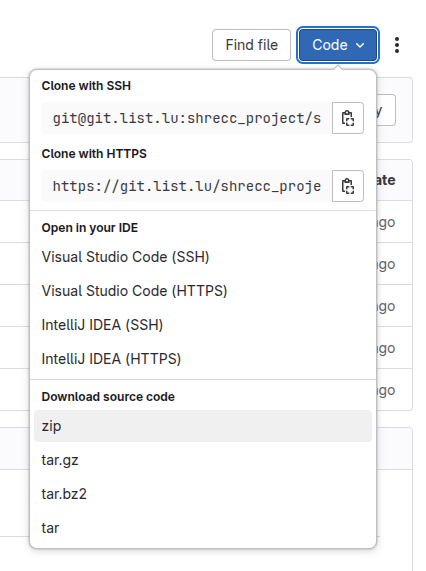

After the download is finished, extract it, and make sure the parent directory is called "data".

And that's literally it! Now it's time to select which countries and times you are interested in and create your database.

## Get your project ready
In order to execute the next cells of this notebook, you need to have a `brightway` (2 or 2.5) project with ecoinvent installed. Matching of electricity sources is valid for ecoinvent 3.9.1, but should be compatible with 3.10 and 3.11. You also need to have a `pandas` dataframe with all the electricity data. Either you created it on your own with the above steps, or you downloaded it from [the shrecc git repository](https://git.list.lu/shrecc_project/shrecc_data).

In [6]:
PROJECT_NAME = "ecoinvent311"

In [7]:
bd.projects.set_current(PROJECT_NAME)

In [8]:
bd.databases

Databases dictionary with 0 objects

In [ ]:
if "ecoinvent-3.11-cutoff" not in bd.databases:
    bi.import_ecoinvent_release(
        version="3.11",
        system_model="cutoff",
        username="XX",
        password="YY",
    )

## Example 1: all days in June around noon
In this example, we model the consumption mix of five countries (1), around noon (2) on all days in June 2024 (3).

### Filter the data
For this, we use the `filt_cutoff` function, specifying the following:

1. The list of countries (a list of strings with the code for each country) ➡️ `countries`
2. The start and end dates ➡️ `general_range`
3. a list of start and end hours ➡️ `refined_range` = [10, 14]
4. a frequency by hour ➡️ `freq` = "h"
5. a cutoff value ➡️ `cutoff` = 1e-3
6. Wether or not to include the cutoff ➡️ `include_cutoff` = True
7. The path where the entso-e data is located ➡️ `path_to_data` PATH_TO_DATA (defined above)


In [ ]:
countries = ["FI", "SE", "LU", "AT", "FR"]

In [ ]:
example = filt_cutoff(
    countries=countries,
    general_range=["2024-06-01 01:00:00", "2024-06-30 23:00:00"],
    refined_range=[10, 14],
    freq="h",
    cutoff=1e-3,
    include_cutoff=True,
    path_to_data=PATH_TO_DATA,
)
# if no path given, shrecc will look for the data inside of shrecc/data

### Create a database based on our filtered and cut off dataframe with selected days/times

In [ ]:
example.head()

In [ ]:
create_database(
    dataframe_filt=example,
    project_name=PROJECT_NAME,
    db_name="elec_june_2024_noon",
    eidb_name="ecoinvent-3.11-cutoff",
)

## Example 2: all days on February evenings
Another example of dataframe, this time on February evenings

In [ ]:
example2 = filt_cutoff(
    countries=countries,
    general_range=["2024-02-01 01:00:00", "2024-02-28 23:00:00"],
    refined_range=[19, 23],
    freq="h",
    cutoff=1e-3,
    include_cutoff=True,
    path_to_data=PATH_TO_DATA,
)
# if no path given, shrecc will look for the data in shrecc/data

In [ ]:
create_database(
    dataframe_filt=example2,
    project_name=PROJECT_NAME,
    db_name="elec_february_2024_evening",
    eidb_name="ecoinvent-3.11-cutoff",
)

## Show that shrecc results are similar enough to ecoinvent

We compare 2021 Energy-Charts data with ecoinvent 3.11 cutoff, which uses 2021 data for most European countries (except of Switzerland).
You can download our data from shrecc_project/shrecc_data/2021. Supply the path to were you saved the data.

In [ ]:
data = get_data(year=2021, path_to_data=PATH_TO_DATA)
# if no path given, shrecc will create a folder inside of shrecc/data, download the data and save it there

In [ ]:
data_processing(data_df=data, year=2021, path_to_data=PATH_TO_DATA)
# if no path given, shrecc will create a folder inside of shrecc/data, download the data and save it there

Selecting all the countries that do not contain missing data:

In [11]:
countries = [
    "AT",
    "BE",
    "CZ",
    "DE",
    "DK",
    "ES",
    "FI",
    "FR",
    "GR",
    "HU",
    "IE",
    "IT",
    "LU",
    "NL",
    "NO",
    "PL",
    "PT",
    "RO",
    "SE",
    "SK",
    "SI",
]

In [12]:
year2021 = filt_cutoff(
    countries=countries,
    general_range=["2021-01-01 00:00:00", "2021-12-31 23:00:00"],
    freq="h",
    cutoff=1e-8,
    include_cutoff=True,
    path_to_data=PATH_TO_DATA,
)

Using mapping root: data/
Mapping technologies...
Technologies mapped.
Filtering dataframe...
Dataframe filtered.


/opt/app/shrecc/database.py:332: PerformanceWarning: indexing past lexsort depth may impact performance.
  df_filt.loc[


In [13]:
create_database(
    dataframe_filt=year2021,
    project_name=PROJECT_NAME,
    db_name="full year 2021",
    eidb_name="ecoinvent-3.11-cutoff",
)

Couldnt find activity:electricity, high voltage, biofuels, import from Germany, CH
Couldnt find activity:electricity, high voltage, hydro, reservoir, import from France, CH
Couldnt find activity:electricity, high voltage, hydro, run-of-river, import from France, CH
Couldnt find activity:electricity, high voltage, natural gas, import from Germany, CH
Couldnt find activity:electricity, high voltage, nuclear, import from France, CH
Couldnt find activity:electricity, high voltage, wind power, import from Germany, CH
Couldnt find activity:electricity, low voltage, photovoltaic, import from Germany, CH
Couldnt find activity:electricity, medium voltage, municipal waste incineration, import from Germany, CH
Couldnt find activity:treatment of digester sludge, municipal incineration, future, CH


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 21/21 [00:00<00:00, 119.47it/s]

15:26:21 [info     ] Vacuuming database            


In [14]:
import bw2calc as bc

In [15]:
ef_methods = [m for m in bd.methods if m[1] == "EF v3.0"]
config = {"impact_categories": ef_methods}

In [16]:
demands_year = {
    f"{a['name']}, full year": {a["id"]: 1} for a in bd.Database("full year 2021")
}

In [17]:
acts_ei = [
    bd.get_node(
        database="ecoinvent-3.11-cutoff",
        location=country,
        name="market for electricity, low voltage",
    )
    for country in sorted(countries)
]

In [18]:
demands_year.update({f"{a['name']}, {a['location']}": {a["id"]: 1} for a in acts_ei})

In [19]:
data_objs = bd.get_multilca_data_objs(
    functional_units=demands_year, method_config=config
)

In [20]:
m_lca = bc.MultiLCA(demands=demands_year, method_config=config, data_objs=data_objs)

In [21]:
m_lca.lci()

In [22]:
m_lca.lcia()

In [23]:
results = []
for (method, fu), score in m_lca.scores.items():
    demand = m_lca.demands[fu]
    a_id = list(demand).pop()
    a = bd.get_activity(a_id)
    results.append(
        {
            "activity": a["name"],
            "database": a["database"],
            "location": a["location"],
            "production amount": demand[a_id],
            "activity unit": a["unit"],
            "reference product": a["reference product"],
            "methodology": method[1],
            "category": method[2],
            "indicator": method[3],
            "score": score,
            "unit": bd.Method(method).metadata["unit"],
        },
    )
res_df = pd.DataFrame(results)
res_df = res_df.set_index([c for c in res_df.columns if c != "score"]).unstack(
    ["category", "indicator", "unit"]
)

In [24]:
res_df.sort_index(level="location", inplace=True)

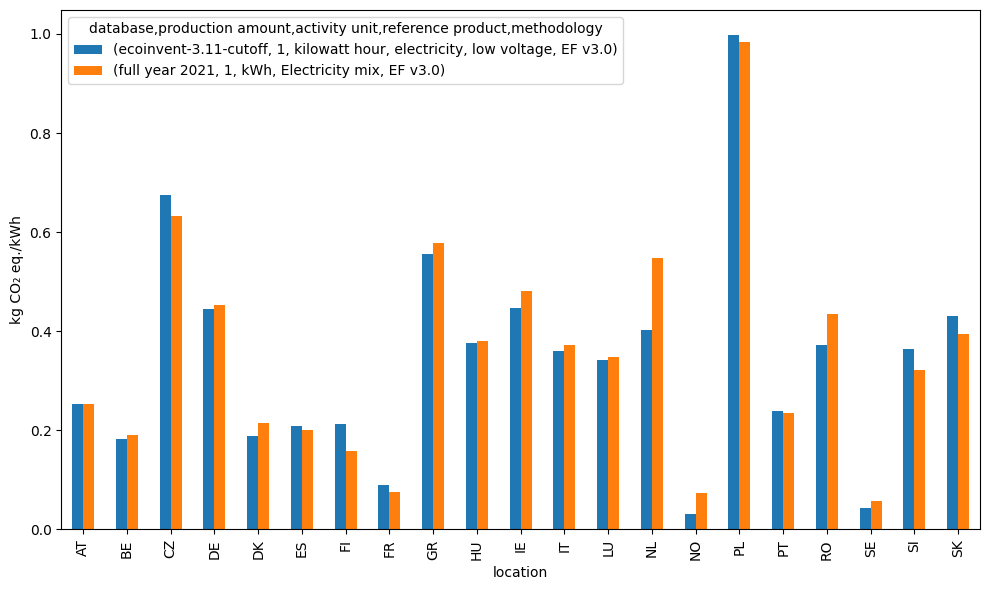

In [25]:
data = res_df[
    ("score", "climate change", "global warming potential (GWP100)", "kg CO2-Eq")
]
data = data.droplevel("activity")
data = data.loc[data.index.get_level_values("location").isin(countries)]
data = data.unstack("location").T

ax = data.plot.bar(figsize=(10, 6))
ax.set_ylabel("kg CO₂ eq./kWh")

import matplotlib.pyplot as plt

plt.tight_layout()
plt.show()

There are differences in some countries, namely Norway and The Netherlands.In Norway, we recommend setting the cut off to 0, as small imports are summed together and European mix is used as the source. For most countries, that is fine, but in this specific case, Norwegian electricity is very low impact, so using the European average skews it a lot. In case of The Netherlands, there are some issues in solar power reporting, and this will be fixed in the future versions of shrecc.

# Test
We run an LCA for the 4 mix samples, as well as their ecoinvent 3.11 equivalents. It is fair to say that here, we are using 2024 data (shrecc) and ecoinvent 3.11 (2021 data), so the results also differ due to changes in the grid.

In [26]:
countries = ["AT", "FR", "LU", "SE", "FI"]

In [27]:
demands_summer_noon = {
    f"{a['name']}, summer, noon": {a["id"]: 1}
    for a in bd.Database("elec_june_2024_noon")
}
demands_winter_evening = {
    f"{a['name']}, winter, evening": {a["id"]: 1}
    for a in bd.Database("elec_february_2024_evening")
}
demands = {**demands_summer_noon, **demands_winter_evening}

In [28]:
acts_ei = [
    bd.get_node(
        database="ecoinvent-3.11-cutoff",
        location=country,
        name="market for electricity, low voltage",
    )
    for country in sorted(countries)
]
acts_ei

['market for electricity, low voltage' (kilowatt hour, AT, None),
 'market for electricity, low voltage' (kilowatt hour, FI, None),
 'market for electricity, low voltage' (kilowatt hour, FR, None),
 'market for electricity, low voltage' (kilowatt hour, LU, None),
 'market for electricity, low voltage' (kilowatt hour, SE, None)]

In [29]:
demands.update({f"{a['name']}, {a['location']}": {a["id"]: 1} for a in acts_ei})
demands

{'Electricity mix in LU, summer, noon': {231017788359184384: 1},
 'Electricity mix in SE, summer, noon': {231017788359184385: 1},
 'Electricity mix in FR, summer, noon': {231017788329824258: 1},
 'Electricity mix in FI, summer, noon': {231017788329824257: 1},
 'Electricity mix in AT, summer, noon': {231017788329824256: 1},
 'Electricity mix in FR, winter, evening': {231018132996755458: 1},
 'Electricity mix in AT, winter, evening': {231018132996755456: 1},
 'Electricity mix in SE, winter, evening': {231018133026115585: 1},
 'Electricity mix in LU, winter, evening': {231018133026115584: 1},
 'Electricity mix in FI, winter, evening': {231018132996755457: 1},
 'market for electricity, low voltage, AT': {139717708668215296: 1},
 'market for electricity, low voltage, FI': {139717795129597953: 1},
 'market for electricity, low voltage, FR': {139717687646363648: 1},
 'market for electricity, low voltage, LU': {139717592968339457: 1},
 'market for electricity, low voltage, SE': {13971779921904

In [30]:
data_objs = bd.get_multilca_data_objs(functional_units=demands, method_config=config)

In [31]:
m_lca = bc.MultiLCA(demands=demands, method_config=config, data_objs=data_objs)

In [32]:
m_lca.lci()

In [33]:
m_lca.lcia()

In [34]:
results = []
for (method, fu), score in m_lca.scores.items():
    demand = m_lca.demands[fu]
    a_id = list(demand).pop()
    a = bd.get_activity(a_id)
    # prod_e = list(a.production()).pop()
    results.append(
        {
            "activity": a["name"],
            "database": a["database"],
            "location": a["location"],
            "production amount": demand[a_id],
            "activity unit": a["unit"],
            "reference product": a["reference product"],
            "methodology": method[0],
            "category": method[1],
            "indicator": method[2],
            "score": score,
            "unit": bd.Method(method).metadata["unit"],
        },
    )
res_df = pd.DataFrame(results)
res_df = res_df.set_index([c for c in res_df.columns if c != "score"]).unstack(
    ["category", "indicator", "unit"]
)

In [35]:
res_df.sort_index(level="location", inplace=True)

Text(0, 0.5, 'kg CO2 eq./kWh')

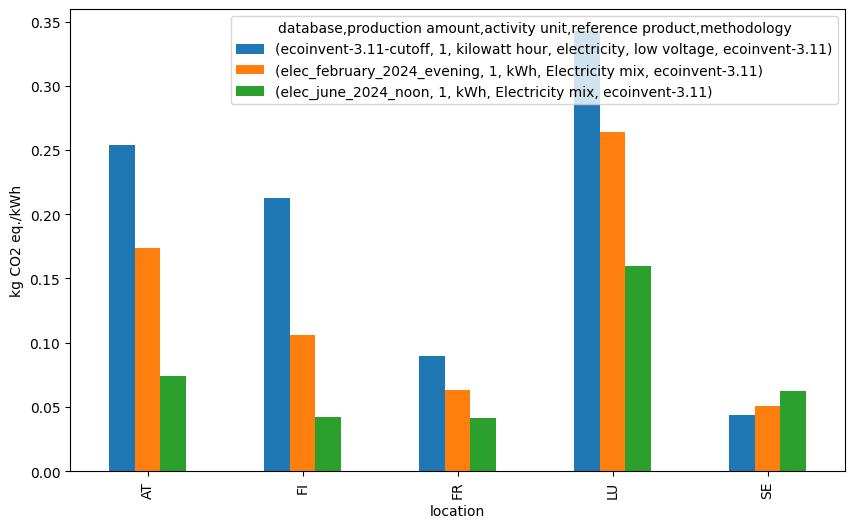

In [36]:
ax = (
    res_df[("score", "EF v3.0", "climate change", "kg CO2-Eq")]
    .droplevel(["activity"])
    .unstack(["location"])
    .T.plot.bar(figsize=(10, 6))
)
ax.set_ylabel("kg CO2 eq./kWh")

# Further analysis and comparisons

The following code uses the `invert_technosphere_matrix` method of the base bw2calc LCA class.
For this method to work correctly, the version of **bw2calc must be**: `>= 2.1`

In [37]:
m_lca.lci()

In [ ]:
m_lca.invert_technosphere_matrix()

In [ ]:
m_lca.demands

In [ ]:
matrix_indices = [
    {k: m_lca.activity_dict[vk] for vk in v.keys()} for k, v in m_lca.demands.items()
]
matrix_indices

In [ ]:
m_lca.inverted_technosphere_matrix.shape

In [ ]:
demands_inverted = {
    k: m_lca.inverted_technosphere_matrix[:, v]
    for d in matrix_indices
    for k, v in d.items()
}

In [ ]:
reversed_activity_dict = {v: k for k, v in m_lca.activity_dict.items()}

In [ ]:
matrix_index = [
    bd.get_activity(reversed_activity_dict[i])
    for i in range(m_lca.inverted_technosphere_matrix.shape[0])
]

In [ ]:
properties = [
    "name",
    "unit",
    "code",
    "location",
    "reference product",
    "type",
    "database",
    "id",
]
df_index = pd.MultiIndex.from_tuples(
    [[m[prop] for prop in properties] for m in matrix_index], names=properties
)

In [ ]:
demands_inverted_df = pd.DataFrame(demands_inverted, index=df_index)

In [ ]:
process_contribution = demands_inverted_df.sort_values(
    by=demands_inverted_df.columns[0], ascending=False
)

In [ ]:
idx_elec = process_contribution.index.get_level_values("name").str.startswith(
    "electricity production"
)

In [ ]:
process_contribution_elec = (
    process_contribution.loc[idx_elec]
    .sort_index(axis=1)
    .droplevel(["unit", "code", "reference product", "type", "database", "id"])
)
process_contribution_elec

In [ ]:
country = "lu"
threshold = 0.05

In [ ]:
for country in countries:
    process_contribution_elec_c = process_contribution_elec[
        [c for c in process_contribution_elec if country in c]
    ]

    idx_filt = (process_contribution_elec_c >= threshold).any(axis=1)
    mix_to_plot = pd.concat(
        [
            process_contribution_elec_c.loc[idx_filt],
            pd.DataFrame(
                process_contribution_elec_c[~idx_filt].sum(), columns=[("REST", "REST")]
            ).T,
        ],
        axis=0,
    ).T  # .droplevel(['code','unit'], axis=0)

    ax = mix_to_plot.plot.bar(stacked=True)
    h, l = ax.get_legend_handles_labels()
    ax.legend(
        loc="center left", bbox_to_anchor=(1.05, 0.5), handles=h[::-1], labels=l[::-1]
    )
    ax.set_title(
        f"Comparison of background process contribution for electricity-producing activities\nbetween shrecc and ecoinvent, for location {country}"
    )

Some remarks about the mix analysis.

1. From the comparison of background processes in Sweden, you can see that the electricity mix done by shrecc contains some aggregated data for hydro electricity. On the Energy Chart API, there is no distinction between the types, and so all hydro (run-off-river, reservoir, hydro pumped storage) is together in one category. Ecoinvent has the different types in the mix.
2. Not all background processes sum to one; we performed our search based on "electricity production", and there might be some activities with a different name, still contributing to the electricity mix.